In [43]:
!pip install -q ultralytics opencv-python torch torchvision kaggle pillow

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import torch
import torch.nn as nn
import torchvision.models as models

class CSRNet(nn.Module):
    def __init__(self, load_pretrained=True):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if load_pretrained else None)
        self.frontend = nn.Sequential(*list(vgg.features)[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [45]:
# Install ultralytics if not already done
!pip install -q ultralytics

from ultralytics import YOLO

# Load YOLO model (pretrained COCO human detector)
yolo = YOLO("yolov8n.pt")   # or path to your fine-tuned weights
print("✅ YOLO model loaded")


✅ YOLO model loaded


In [46]:
import torch
import torch.nn as nn
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_pretrained=True):
        super().__init__()
        vgg = models.vgg16_bn(
            weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if load_pretrained else None
        )
        # use features up to conv5_3 (layer 33 in vgg16_bn)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Sequential(
            nn.Conv2d(128, 1, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

csrnet = CSRNet(load_pretrained=False).to(device)

state = torch.load("/content/drive/My Drive/csrnet_best_partA_testB.pth",
                   map_location=device)
csrnet.load_state_dict(state, strict=True)
csrnet.eval()

print("✅ CSRNet model loaded with Task‑2 weights")


✅ CSRNet model loaded with Task‑2 weights


In [48]:
import cv2
import numpy as np
from PIL import Image
import time


def preprocess(img):
    """Preprocess image for CSRNet"""
    img = cv2.resize(img, (1024, 768))
    img = img / 255.0
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
    return img


def hybrid_count(frame):
    """Hybrid: YOLO detection + CSRNet density"""
    results = yolo(frame)[0]

    clean_frame = frame.copy()

    yolo_count = 0
    density_sum = 0.0

    DENSITY_SCALE = 0.25

    for box in results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        if cls == 0 and conf > 0.5:  # PERSON only
            yolo_count += 1

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            person_crop = frame[y1:y2, x1:x2]

            if person_crop.size == 0:
                continue

            # CSRNet density
            inp = preprocess(person_crop)
            with torch.no_grad():
                density_map = csrnet(inp).detach().cpu().numpy()[0, 0]
            density = density_map.sum() * DENSITY_SCALE

            density_sum += density

            # Draw bounding box + density label (new colors)
            cv2.rectangle(clean_frame, (x1, y1), (x2, y2), (0, 180, 180), 2)
            cv2.putText(
                clean_frame,
                f"D:{density:.1f}",
                (x1, max(0, y1 - 8)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),
                2,
                lineType=cv2.LINE_AA,
            )

    # ---------- FUSION LOGIC ----------
    if yolo_count <= 5:
        # For small crowds, YOLO is more accurate
        final_count = yolo_count
    else:
        # For bigger crowds, fuse YOLO + Density
        final_count = int(0.7 * yolo_count + 0.3 * density_sum)

        # If YOLO misses too many (common in dense crowd)
        if yolo_count < 3 and density_sum > final_count:
            final_count = int(density_sum)

    # ---------- CROWD ALERT (threshold 10) ----------
    alert = "SAFE"
    color = (80, 220, 120)   # soft green

    if final_count > 10:
        alert = "CROWD ALERT"
        color = (60, 60, 255)  # strong red

    # Background bar for readability
    h, w = clean_frame.shape[:2]
    cv2.rectangle(clean_frame, (0, 0), (w, 60), (0, 0, 0), -1)

    # Line 1: summary in yellow
    cv2.putText(
        clean_frame,
        f"YOLO: {yolo_count}   Density: {density_sum:.1f}",
        (10, 25),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 255),
        2,
        lineType=cv2.LINE_AA,
    )

    # Line 2: final count + alert in `color`
    cv2.putText(
        clean_frame,
        f"Final Count: {final_count}   {alert}",
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        color,
        2,
        lineType=cv2.LINE_AA,
    )

    return clean_frame, final_count, alert


print("✅ Hybrid counting function ready")


✅ Hybrid counting function ready


In [49]:
# Download Mall dataset from Kaggle
# You need kaggle.json in ~/.kaggle/
# !kaggle datasets download -d chaozhuang/mall-dataset

import zipfile
import os


# List structure
for root, dirs, files in os.walk('/content/mall_data'):
    level = root.replace('/content/mall_data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    for file in files[:3]:
        print(f'{indent}  {file}')


In [50]:
from IPython.display import clear_output, display
from PIL import Image
import time

mall_frames_dir = '/content/drive/My Drive/mall_data/frames'
test_frames = sorted(os.listdir(mall_frames_dir))[:15]

for frame_file in test_frames:
    frame_path = os.path.join(mall_frames_dir, frame_file)
    frame = cv2.imread(frame_path)

    if frame is not None:
        output, count, alert = hybrid_count(frame)
        rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        display(Image.fromarray(rgb))

        print(f"Frame: {frame_file} | Count: {count:.0f} | Alert: {alert}")
        time.sleep(0.2)

print("✅ Inference on Mall dataset complete!")


✅ Inference on Mall dataset complete!


In [51]:
import os
import cv2
import numpy as np
import scipy.io as sio

mall_data_path = '/content/drive/My Drive/mall_data'
frames_dir = os.path.join(mall_data_path, 'frames', 'frames')

all_frames = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])
print(f"✅ Found {len(all_frames)} frames in: {frames_dir}")

gt_mat_path = os.path.join(mall_data_path, 'mall_gt.mat')
gt_data = sio.loadmat(gt_mat_path)

print("GT keys:", gt_data.keys())

# mall_gt.mat: 'count' is crowd count per frame, in order
raw_counts = gt_data['count'].flatten()
counts = np.array([float(x) if np.isscalar(x) else float(x[0]) for x in raw_counts])

# Just use 1..N as frame indices to align with sorted frames
frame_indices = np.arange(1, len(all_frames) + 1, dtype=int)

print("Processed:")
print("  frame_indices shape:", frame_indices.shape, "example:", frame_indices[:5])
print("  counts shape:", counts.shape, "example:", counts[:5])
print("  min/max frame index:", frame_indices.min(), frame_indices.max())

for fname in all_frames[:3]:
    fpath = os.path.join(frames_dir, fname)
    img = cv2.imread(fpath)
    print(f"Sample frame: {fname} | shape: {img.shape}")

print("\n✅ Mall dataset ready (frames + GT)")


✅ Found 2000 frames in: /content/drive/My Drive/mall_data/frames/frames
GT keys: dict_keys(['__header__', '__version__', '__globals__', 'frame', 'count'])
Processed:
  frame_indices shape: (2000,) example: [1 2 3 4 5]
  counts shape: (2000,) example: [         29          30          35          31          26]
  min/max frame index: 1 2000
Sample frame: seq_000001.jpg | shape: (480, 640, 3)
Sample frame: seq_000002.jpg | shape: (480, 640, 3)
Sample frame: seq_000003.jpg | shape: (480, 640, 3)

✅ Mall dataset ready (frames + GT)


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import os

class MallDataset(Dataset):
    def __init__(self, frames_dir, frame_indices, counts, num_samples=None):
        self.frames_dir = frames_dir
        self.all_frames = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

        self.frame_paths = []
        self.frame_counts = []

        for idx, c in zip(frame_indices, counts):
            py_idx = idx - 1  # 1-based to 0-based
            if 0 <= py_idx < len(self.all_frames):
                self.frame_paths.append(self.all_frames[py_idx])
                self.frame_counts.append(float(c))

        if num_samples is not None:
            self.frame_paths = self.frame_paths[:num_samples]
            self.frame_counts = self.frame_counts[:num_samples]

        print(f"📊 MallDataset created with {len(self.frame_paths)} samples")

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, i):
        frame_name = self.frame_paths[i]
        frame_path = os.path.join(self.frames_dir, frame_name)
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = cv2.resize(img, (1024, 768))

        img_t = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)

        # pseudo density label from current CSRNet
        with torch.no_grad():
            inp = img_t.unsqueeze(0).to(device)
            density_label = csrnet(inp).detach()   # 1×1×H×W

        return img_t, density_label.squeeze(0), torch.tensor(self.frame_counts[i], dtype=torch.float32)

# ----- create DataLoader -----
mall_ds = MallDataset(frames_dir, frame_indices, counts, num_samples=200)
mall_loader = DataLoader(mall_ds, batch_size=4, shuffle=True, num_workers=0)

# ----- fine‑tune -----
csrnet.train()
optimizer = optim.Adam(csrnet.parameters(), lr=1e-5)
criterion = nn.MSELoss()

for epoch in range(5):
    total_loss = 0.0
    steps = 0

    for imgs, dens, gt_counts in mall_loader:
        imgs = imgs.to(device)
        dens = dens.to(device)

        optimizer.zero_grad()
        preds = csrnet(imgs)
        loss = criterion(preds, dens.unsqueeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        steps += 1

    print(f"Epoch {epoch+1}/5 - Loss: {total_loss/steps:.6f}")

csrnet.eval()
torch.save(csrnet.state_dict(), '/content/drive/My Drive/csrnet_finetuned_mall.pth')
print("✅ Fine‑tuning on Mall dataset complete, model saved.")


📊 MallDataset created with 200 samples
Epoch 1/5 - Loss: 0.000589
Epoch 2/5 - Loss: 0.000022
Epoch 3/5 - Loss: 0.000004
Epoch 4/5 - Loss: 0.000001
Epoch 5/5 - Loss: 0.000000
✅ Fine‑tuning on Mall dataset complete, model saved.


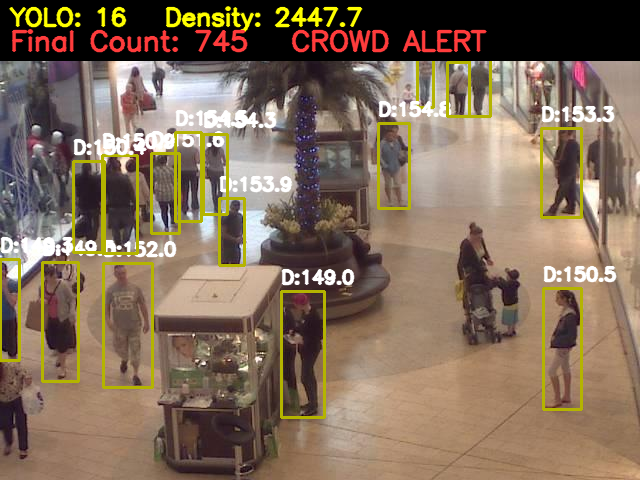

Frame: seq_000020.jpg | Final Count: 745 | Alert: CROWD ALERT
✅ Inference on Mall dataset done.


In [53]:
from IPython.display import clear_output, display
from PIL import Image
import time

test_frames = all_frames[:20]  # from Cell 7

print(f"Testing hybrid_count on {len(test_frames)} Mall frames...\n")

for fname in test_frames:
    fpath = os.path.join(frames_dir, fname)
    frame = cv2.imread(fpath)
    if frame is None:
        continue

    output, count, alert = hybrid_count(frame)  # YOLO + CSRNet function from earlier cells
    rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    display(Image.fromarray(rgb))
    print(f"Frame: {fname} | Final Count: {count:.0f} | Alert: {alert}")
    time.sleep(0.15)

print("✅ Inference on Mall dataset done.")

